### Задача:
На основе анализа данных сделать выводы об эффективности рекламных источников. Обозначить рекомендации по выбору рекламной площадки для продвижения игры.

### План:
1. Загрузка и предобработка данных
2. Анализ поведения пользователей в игре:
    - Каким образом пользователи проходят первый уровень
    - Порядок постройки зданий
    - Скорость прохождения
3. Анализ эффективности рекламных источников.
4. Проверка гипотез:
    + Время прохождения различается в зависимости от выбора типа прохождения
    + Средняя стоимость привлечения одного пользователя у разных источников разная.

5. Вывод

### 1. Загрузка и предобработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import numpy as np
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 40
pd.set_option('max_colwidth', 150)

In [2]:
game_actions = pd.read_csv('game_actions.csv') #загружаем данные о действиях пользователей
ad_cost = pd.read_csv('ad_costs.csv') #загружаем информацию о стоимости кликов
user_source = pd.read_csv('user_source.csv') #загружаем информацию об источниках

In [3]:
game_actions.head()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


In [4]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


В столбцах building_type и project_type есть пропуски, но они, скорее всего, появились потому что, пользователь может пройти уровень двумя способами. Проверим.

In [5]:
game_actions.loc[(game_actions['project_type'].isnull()) & (game_actions['building_type'].isnull())]['event_datetime'].count() + \
game_actions.loc[game_actions['project_type'].isnull() & (game_actions['event'] != 'finished_stage_1')]['event_datetime'].count() + \
game_actions.loc[game_actions['building_type'].isnull() & (game_actions['event'] != 'finished_stage_1')]['event_datetime'].count()

135640

Сумма строк с пропусками в project_type и building_type и строк с завершением 1 уровня равна общему количеству действий в датасете. Заменим пропуски на значение 0.

In [6]:
game_actions = game_actions.fillna(0)

In [7]:
game_actions.duplicated().sum() #проверим на наличие дубликатов

1

In [8]:
game_actions = game_actions.drop_duplicates() #удалим

In [9]:
game_actions['project_type'].unique()

array([0, 'satellite_orbital_assembly'], dtype=object)

In [10]:
game_actions = game_actions.replace({'project_type':{'satellite_orbital_assembly':1}})
#для удобства вычислений, пометим событие с выполнением проекта цифрой 1

In [11]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
#приведём значения event_datetime к типу "datetime"

In [12]:
ad_cost.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


In [13]:
ad_cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


In [14]:
ad_cost['day'] = pd.to_datetime(ad_cost['day'])

In [15]:
user_source.head()

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [16]:
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


Заменены пропуски, удалены дубликаты, столбцы приведены к необходимым типам. Можно приступать к анализу.

### 2. Анализ поведения пользователей в игре.

In [17]:
game_actions['event'].unique()

array(['building', 'finished_stage_1', 'project'], dtype=object)

Есть три вида события: постройка, прохождение первого уровня и проект. Посмотрим, отмечается ли завершением проекта прохождением первого уровня.

In [18]:
display(game_actions.query('event == "project"')['user_id'].nunique())
id_final_stage_1 = game_actions.query('event == "finished_stage_1"')['user_id'].to_list()
display(game_actions.query('event == "project" & user_id in @id_final_stage_1')['user_id'].nunique())

1866

1866

Все, кто завершил проект, прошли первый уровень. Посмотрим, какая доля, вообще проходит первый уровень.

In [19]:
all_users = game_actions['user_id'].nunique()
over = game_actions.query('event == "finished_stage_1"')['user_id'].nunique()
project_users = game_actions.query('event == "project"')['user_id'].nunique()

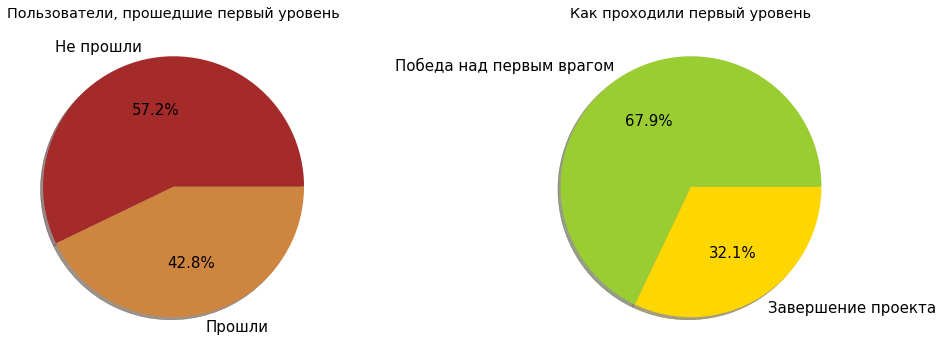

In [20]:
plt.figure(figsize=(17,6))
plt.subplot(1, 2, 1)
plt.title('Пользователи, прошедшие первый уровень')
plt.pie([all_users-over, over], 
        labels=['Не прошли', 'Прошли'],
        colors = ['brown','peru'],
        autopct = "%0.1f%%",
        textprops = {"fontsize":15},
        shadow = True)
plt.subplot(1, 2, 2)
plt.title('Как проходили первый уровень')
plt.pie([over-project_users, project_users], 
        labels=['Победа над первым врагом', 'Завершение проекта'],
        colors = ['yellowgreen','gold'],
        autopct = "%0.1f%%",
        textprops = {"fontsize":15},
        shadow = True)
plt.show()

Больше половины пользователей вообще не проходят первый уровень, а именно 57.15% от общего количества. Очень большая доля пользователей отваливается. Значит, либо неинтересно, либо сложно. Всего треть пользователей выбирает прохождение через выполнение проекта. Возможно, это связано со разной скоростью или сложностью прохождения.

In [21]:
project_user_id = game_actions.query('project_type == 1')['user_id'].unique()
#список пользователей, которые прошли уровень через постройку объекта

In [22]:
project_building = game_actions.query('building_type != 0 & user_id in @project_user_id')\
                  .groupby('user_id')\
                  .agg({'building_type':'nunique'}).reset_index()

In [23]:
project_building['building_type'].unique()

array([3], dtype=int64)

Все, кто прошли первый уровень через выполнения проекта, построили все три здания.

In [24]:
finished_stage_user_id = game_actions.query('event == "finished_stage_1"')['user_id'].unique()

In [25]:
finished_stage_bulding = game_actions.query('user_id in @finished_stage_user_id')\
                                     .groupby('building_type')\
                                     .agg({'user_id':'nunique'}).reset_index()
finished_stage_bulding['ratio'] = round(finished_stage_bulding['user_id'] / over * 100, 1)

In [26]:
finished_stage_bulding.sort_values(by='ratio', ascending=False)

,building_type,user_id,ratio
0,0,5817,100.0
1,assembly_shop,5817,100.0
3,spaceport,5760,99.0
2,research_center,4208,72.3


Все, кто прошёл первый уровень, построил assembly_shop.

In [27]:
not_finished_stage_bulding = game_actions.query('user_id not in @finished_stage_user_id')\
                                         .groupby('building_type')\
                                         .agg({'user_id':'nunique'}).reset_index()
not_finished_stage_bulding['ratio'] = round(not_finished_stage_bulding['user_id']
                                            / (all_users - over) * 100, 1)

In [28]:
not_finished_stage_bulding.sort_values(by='ratio', ascending=False)

,building_type,user_id,ratio
0,assembly_shop,7759,100.0
2,spaceport,7471,96.3
1,research_center,3463,44.6


Все пользователи в игре построили assembly_shop, почти все - spaceport. Получается, что порядок постройки таков: 
1. assembly_shop
2. spaceport 
3. research_center.

Также мы видим, что значительно меньшая часть пользователей, не прошедших первый уровень по сравнению с прошедшими, строит research_center. Возможно, дело в сложности постройки.

Разобъём пользователей на 3 группы:
1. Прошедшие первый уровень через выполнение проекта.
2. Прошедшие первый уровень через победу над первым врагом.
3. Не прошедшие первый уровень

In [29]:
battle_user_id = game_actions\
                 .query('event == "finished_stage_1" & user_id not in @project_user_id')['user_id']\
                 .unique()
#создаём список пользователей, которые прошли первый уровень через победу над врагом

In [30]:
def type_finished(user_id):
    if user_id in project_user_id:
        return 'project'
    elif user_id in battle_user_id:
        return 'battle'
    else:
        return 'no_finished'
#напишем функцию определения группы пользователя

In [31]:
game_actions['type_finished'] = game_actions.apply(lambda x: type_finished(x['user_id']), axis=1)
#добавим информацию о группе пользователя

In [32]:
main_time = game_actions.pivot_table(index='user_id', 
                                     values=['event_datetime', 'type_finished'],
                                     aggfunc={'event_datetime':['min', 'max'], 'type_finished':'max'})
main_time = main_time.reset_index()
main_time.columns = ['user_id', 'max_time', 'min_time', 'type_finished']
main_time['days_finished'] = (main_time['max_time']- main_time['min_time']).dt.days
main_time = main_time[['type_finished', 'days_finished']]
#создадим таблицу с данными о затраченном времени на прохождение

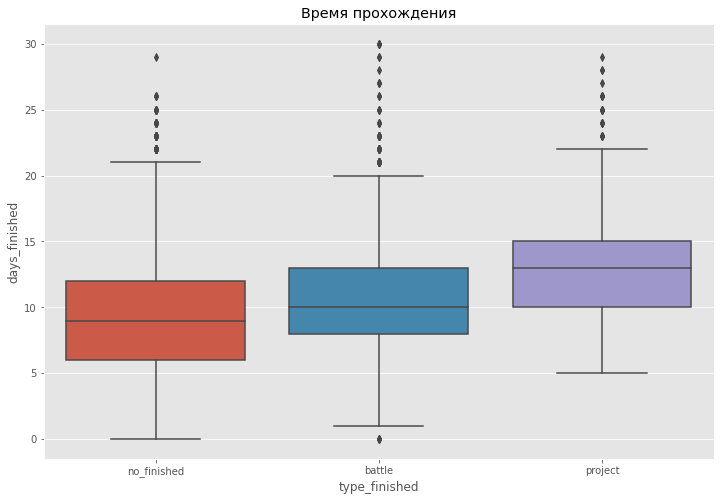

In [33]:
plt.figure(figsize=(12,8))
plt.title('Время прохождения')
ax = sns.boxplot(data = main_time, x='type_finished', y='days_finished')

Меньше всего времени на уровне проводят игроки, не прошедшие уровень. Через победу над первым врагом пользователи проходят быстрее, чем через выполнение проекта. Поэтому выполнивших проект среди тех, кто прошёл первый уровень меньшее количество.

In [34]:
amount_building = game_actions.query('event=="building"')\
                                .groupby(['type_finished','user_id'])\
                                .agg({'event':{'count'}}).reset_index()
amount_building.columns= ['type_finished','user_id','amount_building']
#посчитаем, сколько зданий построил каждый пользователь

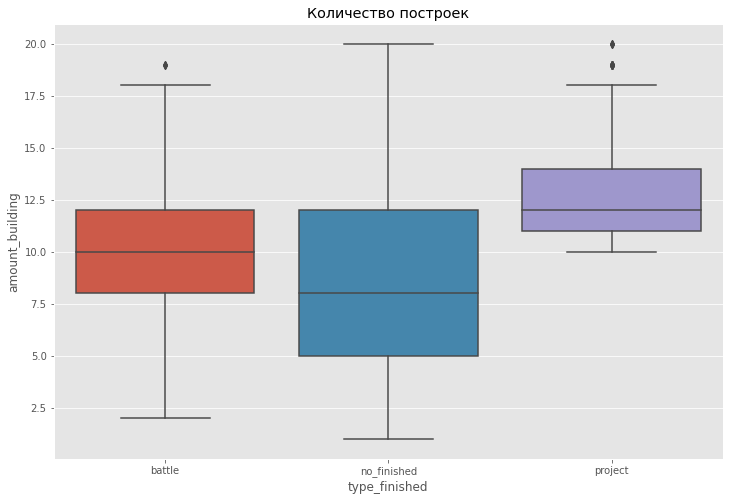

In [35]:
plt.figure(figsize=(12,8))
plt.title('Количество построек')
ax = sns.boxplot(data = amount_building, x='type_finished', y='amount_building')

Больше всего зданий строят пользователи, прошедшие уровень через проект. Минимальное количество зданий такого пользователя такое же, как медианное значение пользователей, завершивших уровень через победу над врагом. У тех, кто не проходит первый уровень - больше всего разброс по количетсву построенных зданий, но в целом, они строят меньше.

In [36]:
mean_building = amount_building.groupby('type_finished')\
                               .agg({'amount_building':'mean'})\
                               .sort_values(by='amount_building', ascending=False)\
                               .reset_index()
mean_building
#посчитаем, сколько зданий в среднем строят пользователи с разным типом прохождения

,type_finished,amount_building
0,project,12.647910
1,battle,9.411541
2,no_finished,8.657043


В среднем, пользователи, прошедшие уровень через проект значительно больше строят зданий.

In [37]:
amount_building_type = game_actions.query('event=="building"')\
                                .pivot_table(index='building_type', 
                                             columns='type_finished',
                                             values='user_id',
                                             aggfunc='count',
                                             margins=True).sort_values(by='battle', ascending=False)
amount_building_type = amount_building_type.reset_index()
amount_building_type
#посчитаем, сколько зданий и каких построили пользователи, выбравшие разный тип прохождения

type_finished,building_type,battle,no_finished,project,All
0,All,37185,67170,23601,127956
1,spaceport,17132,31405,10788,59325
2,assembly_shop,16298,29080,9116,54494
3,research_center,3755,6685,3697,14137


В абсолютных показателях больше всего построек у пользователей, которые не прошли первый уровень, меньше всего - у тех, кто проходил через выполнение проекта. Это объясняется тем, что разное количество пользователей в группах.

Распределение по доле пользователей, построивших конкретное здание(как и порядок постройки зданий) было такое:
1. spaceport
2. assembly_shop
3. research_center

А вот по количеству построенных конкретных зданий распределение мест другое. Больше всего построено spaceport, затем уже assembly_shop и меньше всего(чуть более 10% от всех построенных зданий) research_center.

### 3. Анализ эффективности рекламных источников. 

In [38]:
first_visit = game_actions.pivot_table(index='user_id', values='event_datetime', aggfunc='min')
first_visit = first_visit.reset_index()
first_visit.columns = ['user_id', 'first_visit_datetime']
first_visit['first_visit_date'] = first_visit['first_visit_datetime'].dt.date
#находим время первого визита пользователя

In [39]:
game_actions = game_actions.merge(first_visit, on='user_id').merge(user_source, how='left', on='user_id')
#добавим в датасет информацию о первом визите пользователя и источнике

In [40]:
game_actions['lifetime'] = (game_actions['event_datetime'] 
                            - game_actions['first_visit_datetime']).dt.days
#разобъём все события по 24 часа

In [41]:
cohorts = game_actions.groupby(['type_finished','lifetime']).agg({'user_id':'nunique'}).reset_index()
initial_users_count = cohorts.query('lifetime==0')[['type_finished', 'user_id']]\
                             .rename(columns={'user_id':'cohort_users'})
cohorts = cohorts.merge(initial_users_count, on='type_finished')
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']
#разобъём на когорты и поссчитаем ретеншн

In [42]:
retention_pivot = cohorts.pivot_table(index='lifetime', 
                                      columns='type_finished', 
                                      values='retention', 
                                      aggfunc='sum')
#приведём к удобному виду

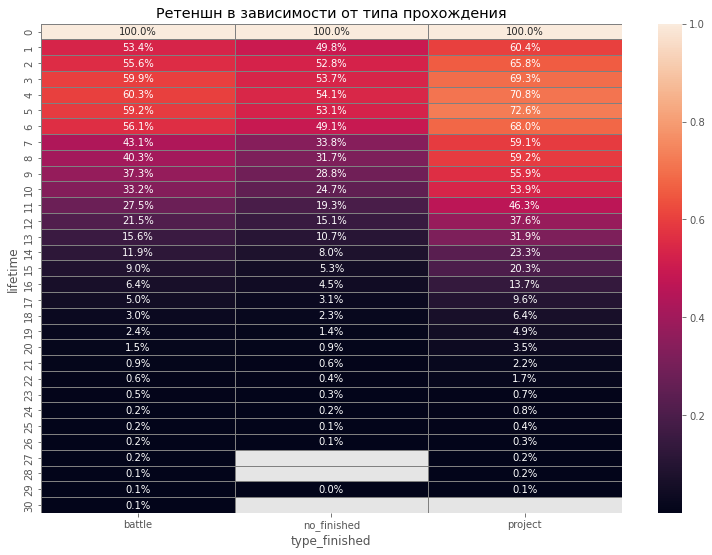

In [43]:
plt.figure(figsize=(13, 9))
plt.title('Ретеншн в зависимости от типа прохождения')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.show()
#построим тепловую карту

Большее удержание показывает когорта пользователей, которая проходила первый уровень через выполнение проекта, потому что время прохождения через выполнение проекта затрачивается больше, чем прохождение через победу над первым врагом.

In [44]:
cohorts_source = game_actions.groupby(['source','lifetime']).agg({'user_id':'nunique'}).reset_index()
initial_users_count_source = cohorts_source.query('lifetime==0')[['source', 'user_id']]\
                                           .rename(columns={'user_id':'cohort_users'})
cohorts_source = cohorts_source.merge(initial_users_count_source, on='source')
cohorts_source['retention'] = cohorts_source['user_id']/cohorts_source['cohort_users']
#разобъём на когорты по источникам и поссчитаем ретеншн

In [45]:
retention_source_pivot = cohorts_source.pivot_table(index='lifetime', 
                                                    columns='source', 
                                                    values='retention', 
                                                    aggfunc='sum')
#приведём к удобному виду

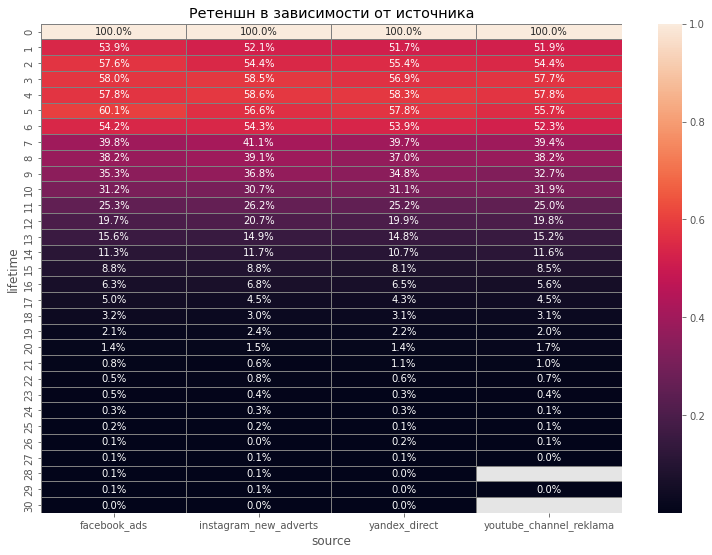

In [46]:
plt.figure(figsize=(13, 9))
plt.title('Ретеншн в зависимости от источника')
sns.heatmap(retention_source_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.show()
#построим тепловую карту

Как видим, ретеншн от источника привлечения не зависит.

In [47]:
pivot_source = game_actions.pivot_table(index='source', 
                                        columns='type_finished', 
                                        values='user_id', 
                                        aggfunc='nunique')
pivot_source = pivot_source.reset_index()
pivot_source.columns = ['source', 'amount_battle', 'amount_no_finished', 'amount_project']
pivot_source['amount_all'] = pivot_source['amount_battle']\
                             +pivot_source['amount_no_finished']\
                             +pivot_source['amount_project']
pivot_source['ratio_battle'] = round(pivot_source['amount_battle']
                                     /pivot_source['amount_all'] *100, 1)
pivot_source['ratio_no_finished'] = round(pivot_source['amount_no_finished']
                                          /pivot_source['amount_all'] *100, 1)
pivot_source['ratio_project'] = round(pivot_source['amount_project']
                                      /pivot_source['amount_all'] *100, 1)
pivot_source = pivot_source.sort_values(by='amount_all', ascending=False)
pivot_source

,source,amount_battle,amount_no_finished,amount_project,amount_all,ratio_battle,ratio_no_finished,ratio_project
2,yandex_direct,1422,2775,620,4817,29.5,57.6,12.9
1,instagram_new_adverts,990,1881,476,3347,29.6,56.2,14.2
0,facebook_ads,759,1576,391,2726,27.8,57.8,14.3
3,youtube_channel_reklama,780,1527,379,2686,29.0,56.9,14.1


Больше всего пользователей пришло с канала yandex_direct, но с него меньшая доля пользователей, которые выбирают прохождение уровня через выполнение проекта.

In [48]:
all_cost = ad_cost.groupby('source').agg({'cost':'sum'}).reset_index()

In [49]:
pivot_source = pivot_source.merge(all_cost, on='source')
pivot_source['CAC'] = pivot_source['cost']/pivot_source['amount_all']
pivot_source[['source','amount_all','cost','CAC']].sort_values(by='CAC')

,source,amount_all,cost,CAC
3,youtube_channel_reklama,2686,1068.119204,0.397662
0,yandex_direct,4817,2233.111449,0.463590
1,instagram_new_adverts,3347,2161.441691,0.645785
2,facebook_ads,2726,2140.904643,0.785365


Наименьшие затраты на привлечение пользователя показывает канал youtube_channel_reklama, но с этого источника пришло наименьшее количество пользователей, затем идёт yandex_direct, который и привлёк больше всего пользователей. Было бы интересно посмотреть ещё данные о количестве показов и кликов, посчитать CTR, чтобы выяснить, на самом ли деле поток зависит от выбора канала, или необходимо под каждый отдельно разрабатывать свою рекламу, так как в этих каналах разная целевая аудитория. Также количество показов нам может сказать о том, насколько дорогой один показ и, вообще, как часто показывается реклама в каждом канале. Возможно, с источника youtube_channel_reklama пришло пользователей меньше, чем с yandex_direct, потому что выбрана низкая цена одного показа, из-за этого наша реклама проигрывает в рекламном аукционе и меньше показывается аудитории. Из этого и формируется такой хороший показатель CAC. Возможно, увеличив цену одного показа, мы увеличим количество показов и количество привлечённых пользователей, но тогда затраты на привличение одно пользователя вырастут.

###  4. Проверка гипотез

###### Время прохождения различается в зависимости от выбора типа прохождения 

Нулевая гипотеза: время прохождения первого уровня через победу над первым врагом не отличается от времени прохождения через выполнение проекта.

Альтернативная гипотеза: время прохождения первого уровня различается в зависимости от выбора типа прохождения.

In [50]:
def display_var(sel_1, sel_2):
    display(
        'Дисперсия 1: {:.6f}'.format(np.var(sel_1, ddof=1)),
        'Дисперсия 2: {:.6f}'.format(np.var(sel_2, ddof=1)))
#напишем функцию для проверки дисперсий 2х выборок

In [51]:
project_users_time = main_time.query('type_finished == "project"')
battle_users_time = main_time.query('type_finished == "battle"')

In [52]:
display_var(project_users_time['days_finished'], battle_users_time['days_finished'])
#проверим дисперсии на равенство

'Дисперсия 1: 12.437774'

'Дисперсия 2: 16.860053'

Дисперсиии различные, значит параметр equal_var=False.

Критический уровень значимости возьмём 5%.

In [53]:
def t_test_func(sel_1, sel_2, alpha, eq_var):
    results = st.ttest_ind(sel_1, sel_2, equal_var = eq_var)
    display('p-value = {}'.format(results.pvalue))
    if results.pvalue < alpha:
        display('Отвергаем нулевую гипотезу.')
    else:
        display(
            'Не получилось отвергнуть нулевую гипотезу, с вероятностью {:.2%} такое различие можно получить случайно.'.
            format(results.pvalue))
#напишем функцию для проверки гипотезы

In [54]:
t_test_func(project_users_time['days_finished'], battle_users_time['days_finished'], 0.05, False)
#проверим гипотезу

'p-value = 2.6237027268062713e-106'

'Отвергаем нулевую гипотезу.'

Так как p-value получили меньше критического уровня значимости, значит время прохождения первого уровня различается в зависимости от выбора типа прохождения.

######  Средняя стоимость привлечения одного пользователя у разных источников разная.

Нулевая гипотеза: средняя стоимость привлечения одного пользователя у всех источников одинаковая.

Альтернативная гипотеза: средняя стоимость привлечения одного пользователя разная у разных источников.

In [55]:
users_per_source = game_actions.groupby(['source', 'first_visit_date'])\
                               .agg({'user_id':'nunique'})\
                               .reset_index()
users_per_source['first_visit_date'] = pd.to_datetime(users_per_source['first_visit_date'])
users_per_source.columns = ['source', 'day', 'user_id']
#рассчитаем ежедневное количество привлечённых пользователей по источникам

In [56]:
all_cost = ad_cost.merge(users_per_source, on=['source','day'])
all_cost['cost_per_user'] = all_cost['cost']/all_cost['user_id']
all_cost_pivot = all_cost.pivot_table(index='day', 
                                      columns='source', 
                                      values='cost_per_user', 
                                      aggfunc='sum')
#рассчитаем ежедневный САС по источникам

In [57]:
source = all_cost_pivot.columns.to_list() #создадим список названий источников

In [58]:
for i in source:
    for j in reversed(source):
        if i != j:
            display('Сравнение дисперсий {} и {}'.format(i, j))
            display_var(all_cost_pivot[i], all_cost_pivot[j])
        else: 
            break

'Сравнение дисперсий facebook_ads и youtube_channel_reklama'

'Дисперсия 1: 0.002488'

'Дисперсия 2: 0.000783'

'Сравнение дисперсий facebook_ads и yandex_direct'

'Дисперсия 1: 0.002488'

'Дисперсия 2: 0.000260'

'Сравнение дисперсий facebook_ads и instagram_new_adverts'

'Дисперсия 1: 0.002488'

'Дисперсия 2: 0.000777'

'Сравнение дисперсий instagram_new_adverts и youtube_channel_reklama'

'Дисперсия 1: 0.000777'

'Дисперсия 2: 0.000783'

'Сравнение дисперсий instagram_new_adverts и yandex_direct'

'Дисперсия 1: 0.000777'

'Дисперсия 2: 0.000260'

'Сравнение дисперсий yandex_direct и youtube_channel_reklama'

'Дисперсия 1: 0.000260'

'Дисперсия 2: 0.000783'

Дисперсии различные. Значит параметр equal_var=False.

In [59]:
for i in source:
    for j in reversed(source):
        if i != j:
            display('==============================================================================')
            display('Сравнение средней стоимости привлечения {} и {}'.format(i, j))
            t_test_func(all_cost_pivot[i], all_cost_pivot[j], 0.05, False)
            display('==============================================================================')
            display('')
        else: 
            break

'=============================================================================='

'Сравнение средней стоимости привлечения facebook_ads и youtube_channel_reklama'

'p-value = 1.410512322436684e-05'

'Отвергаем нулевую гипотезу.'

'=============================================================================='

''

'=============================================================================='

'Сравнение средней стоимости привлечения facebook_ads и yandex_direct'

'p-value = 0.00010071258653693135'

'Отвергаем нулевую гипотезу.'

'=============================================================================='

''

'=============================================================================='

'Сравнение средней стоимости привлечения facebook_ads и instagram_new_adverts'

'p-value = 0.011153513393843498'

'Отвергаем нулевую гипотезу.'

'=============================================================================='

''

'=============================================================================='

'Сравнение средней стоимости привлечения instagram_new_adverts и youtube_channel_reklama'

'p-value = 4.294567609729548e-06'

'Отвергаем нулевую гипотезу.'

'=============================================================================='

''

'=============================================================================='

'Сравнение средней стоимости привлечения instagram_new_adverts и yandex_direct'

'p-value = 2.1201256723769395e-05'

'Отвергаем нулевую гипотезу.'

'=============================================================================='

''

'=============================================================================='

'Сравнение средней стоимости привлечения yandex_direct и youtube_channel_reklama'

'p-value = 0.06306160545354701'

'Не получилось отвергнуть нулевую гипотезу, с вероятностью 6.31% такое различие можно получить случайно.'

'=============================================================================='

''

Получаем, что у всех источников разная стоимость привлечения одного пользователя. Выделяются только источники yandex_direct и youtube_channel_reklama. Различия в средних стоимостях привлечения пользователя из этих источников с вероятностью 6.31% можно получить случайно.

### Вывод.

1. Пользователи, которые выбирают тип прохождения через выполнение проекта, затрачивают больше времени на прохождение первого уровня, чем те, которые выбирают победу над первым врагом. Различия значимые. Соответственно, пользователь, проходящий уровень через выполнение проекта дольше задерживается в игре на уровне. Однако, таких пользователей в 2 раза меньше, чем тех, кто проходит через победу над врагом. Однако, все пользователи, даже те, которые не проходят первый уровень, строят здания. Как минимум, первое, а у большинства ещё и второе бывает построеным.
2. Пользователи, прошедшие первый уровень через выполнение проекта, в среднем, значительно больше строят зданий. В абсолютных показателях больше всего строят здания те, кто не проходит первый уровень. Значит, даже те, кто не проходит первый уровень, будет обеспечивать нам просмотры рекламы, как следствие, монетизацию. Но LTV таких пользователей будет ниже, так как, они меньше строят здания. Самый выгодный для нас игрок будет тот, кто проходит уровень через выполнение проекта.
3. По количеству построек у пользователя любого типа прохождения/не прохождения, в лидерах spaceport, ненамного меньшие показатели у assembly_shop, совсем небольшие у research_center: чуть более 10% всех построек - доля research_center.
4. Больше всего пользователей пришло с Яндекс.Директ. Однако, пользователи, пришедшие с этого ресурса, реже на 1.2% выбирают выполнение проекта. Но данное различие не очень значительно, особенно учитывая значительные различия в количестве привлечённых пользователей.
5. Наименьшая стоимость привлечения одного пользователя через Яндекс.Директ и Ютуб. Различия в средней стоимости привлечения по сравнению с другими источниками являются значительными.

Рекомендации:
- Выбрать два основных источника привлечения пользователей: Яндекс.Директ и Ютуб.
- Пересмотреть рекламные кампании на площадках Инстраграмм и Фейсбук. Узнать, почему такая высокая стоимость привлечения одного пользователя, возможно, необходимо лучше узнать целевую аудиторию и её боли.
- Добавить сбор данных о количестве показов рекламных объявлений и кликов пользователей, вид рекламы: контекст или таргетинг. Это позволит лучше изучить, что влияет на стоимость привлечения пользователя.
- При внедрении монетизации за счёт рекламы на экране постройки здания необходимо учесть частоту построек: самая дорогая реклама на экране постройки spaceport (так как чаще всего пользователи строят это здание) и на постройке assembly_shop (так как это здание является первой постройкой и его строят все пользователи). На экране research_center будет дешёвая реклама.